Lambda School Data Science

*Unit 4, Sprint 3, Module 1*

---


# Recurrent Neural Networks (RNNs) and Long Short Term Memory (LSTM) (Prepare)

<img src="https://media.giphy.com/media/l2JJu8U8SoHhQEnoQ/giphy.gif" width=480 height=356>
<br></br>
<br></br>

## Learning Objectives
- <a href="#p1">Part 1: </a>Describe Neural Networks used for modeling sequences
- <a href="#p2">Part 2: </a>Apply a LSTM to a text generation problem using Keras

## Overview

> "Yesterday's just a memory - tomorrow is never what it's supposed to be." -- Bob Dylan

Wish you could save [Time In A Bottle](https://www.youtube.com/watch?v=AnWWj6xOleY)? With statistics you can do the next best thing - understand how data varies over time (or any sequential order), and use the order/time dimension predictively.

A sequence is just any enumerated collection - order counts, and repetition is allowed. Python lists are a good elemental example - `[1, 2, 2, -1]` is a valid list, and is different from `[1, 2, -1, 2]`. The data structures we tend to use (e.g. NumPy arrays) are often built on this fundamental structure.

A time series is data where you have not just the order but some actual continuous marker for where they lie "in time" - this could be a date, a timestamp, [Unix time](https://en.wikipedia.org/wiki/Unix_time), or something else. All time series are also sequences, and for some techniques you may just consider their order and not "how far apart" the entries are (if you have particularly consistent data collected at regular intervals it may not matter).

# Neural Networks for Sequences (Learn)

## Overview

There's plenty more to "traditional" time series, but the latest and greatest technique for sequence data is recurrent neural networks. A recurrence relation in math is an equation that uses recursion to define a sequence - a famous example is the Fibonacci numbers:

$F_n = F_{n-1} + F_{n-2}$

For formal math you also need a base case $F_0=1, F_1=1$, and then the rest builds from there. But for neural networks what we're really talking about are loops:

![Recurrent neural network](https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg)

The hidden layers have edges (output) going back to their own input - this loop means that for any time `t` the training is at least partly based on the output from time `t-1`. The entire network is being represented on the left, and you can unfold the network explicitly to see how it behaves at any given `t`.

Different units can have this "loop", but a particularly successful one is the long short-term memory unit (LSTM):

![Long short-term memory unit](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/1024px-Long_Short-Term_Memory.svg.png)

There's a lot going on here - in a nutshell, the calculus still works out and backpropagation can still be implemented. The advantage (ane namesake) of LSTM is that it can generally put more weight on recent (short-term) events while not completely losing older (long-term) information.

After enough iterations, a typical neural network will start calculating prior gradients that are so small they effectively become zero - this is the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), and is what RNN with LSTM addresses. Pay special attention to the $c_t$ parameters and how they pass through the unit to get an intuition for how this problem is solved.

So why are these cool? One particularly compelling application is actually not time series but language modeling - language is inherently ordered data (letters/words go one after another, and the order *matters*). [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) is a famous and worth reading blog post on this topic.

For our purposes, let's use TensorFlow and Keras to train RNNs with natural language. Resources:

- https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py
- https://keras.io/layers/recurrent/#lstm
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/

Note that `tensorflow.contrib` [also has an implementation of RNN/LSTM](https://www.tensorflow.org/tutorials/sequences/recurrent).

## Follow Along

Sequences come in many shapes and forms from stock prices to text. We'll focus on text, because modeling text as a sequence is a strength of Neural Networks. Let's start with a simple classification task using a TensorFlow tutorial. 

### RNN/LSTM Sentiment Classification with Keras

In [1]:
'''
#Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
**Notes**
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, SimpleRNN, LSTM
from tensorflow.keras.datasets import imdb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Set top N words and batch_size
max_features = 20000
batch_size = 32

# Our vectorized labels
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

# Map for readable classnames
class_names = ["Negative", "Positive"]

2022-04-14 22:11:57.540604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-14 22:11:57.540684: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Loading data...
25000 train sequences
25000 test sequences


Reviews in the IMDB dataset have been encoded as a sequence of integers. Luckily the dataset also contains an index for converting the reviews back into human readable form.

In [ ]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,

In [2]:
# Get the word index from the dataset
word_index = imdb.get_word_index()

# Ensure that "special" words are mapped into human readable terms 
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2

# Perform reverse word lookup and make it callable
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1654784/1641221 [==============================] - 1s 1us/step


In [3]:
reverse_word_index[5001]

'spain'

In [4]:
# Concatonate test and training datasets
allreviews = np.concatenate((x_train, x_test), axis=0)

# Review lengths across test and training whole datasets
print("Maximum review length: {}".format(len(max((allreviews), key=len))))
print("Minimum review length: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {}".format(np.mean(result)))

# Print a review and it's class as stored in the dataset. Replace the number
# to select a different review.
print("")
print("Machine readable Review")
print("  Review Text: " + str(x_train[30]))
print("  Review Sentiment: " + str(y_train[30]))

# Print a review and it's class in human readable format. Replace the number
# to select a different review.
print("")
print("Human Readable Review")
print("  Review Text: " + decode_review(x_train[30]))
print("  Review Sentiment: " + class_names[y_train[30]])

Maximum review length: 2494
Minimum review length: 7
Mean review length: 234.75892

Machine readable Review
  Review Text: [1, 13, 1059, 14, 33, 6, 2181, 2824, 32, 13, 70, 135, 9, 51, 4, 609, 14, 20, 299, 46, 44, 17, 9287, 17, 4111, 2914, 886, 4, 229, 18, 6624, 45, 1162, 724, 231, 4, 3638, 227, 7, 281, 5, 60, 48, 25, 81, 563, 129, 1224, 11, 4, 519, 4, 22, 9, 131, 38, 1162, 15, 12, 218, 60, 163, 10, 10, 4, 114, 2290, 4660, 2243, 1230, 9771, 269, 8, 607, 6, 4660, 63, 1367, 6, 3732, 2, 4, 3732, 266, 103, 9771, 8, 79, 68, 2, 145, 9771, 2497, 98, 18, 2, 5, 732, 46, 8, 570, 98, 10, 10, 198, 44, 32, 4, 65, 50, 9, 4, 360, 9, 120, 4, 350, 2, 7, 2435, 1181, 2, 67, 2, 5, 2, 5, 2886, 4331, 206, 844, 33, 31, 213, 9771, 2, 6, 10926, 15977, 5, 3193, 1860, 19, 6, 3732, 1544, 23, 350, 7, 12, 422, 198, 208, 1230, 9771, 3193, 1860, 6, 232, 23, 350, 7, 35, 15977, 387, 15, 30, 129, 3619, 18, 14, 3931, 78, 22]
  Review Sentiment: 0

Human Readable Review
  Review Text: <START> i caught this at a test screen

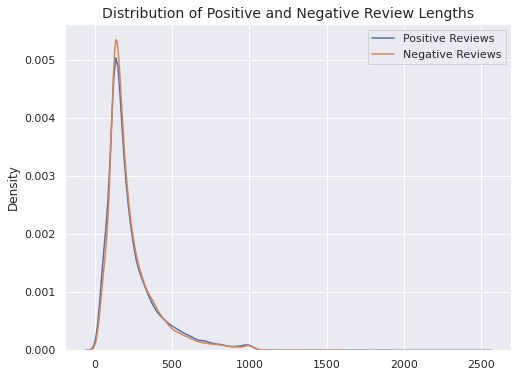

In [5]:
# Get the lengths for positive and negative reviews
all_labels = np.concatenate([y_train, y_test])
positive = np.array(result)[all_labels==1]
negative = np.array(result)[all_labels==0]

plt.figure(figsize=(8,6))
sns.distplot(positive, label='Positive Reviews', hist=False)
sns.distplot(negative, label='Negative Reviews', hist=False)
plt.title('Distribution of Positive and Negative Review Lengths', fontsize=14)
plt.legend();

In [6]:
# If you want to pad the end of the sequences you can set padding='post'.
maxlen = 250

print('Pad Sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

Pad Sequences (samples x time)
x_train shape:  (25000, 250)
x_test shape:  (25000, 250)


In [7]:
x_train[60]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

Let's get a baseline performance for Multi-Layer Perceptron

In [11]:
# THIS WAS ADDED BECAUSE WE GET A SHAPE ERROR WITHOUT IT BUT PREVIOUS TESTS WERE BETTER

# Our vectorized labels
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [12]:
mlp = Sequential()
# EMBEDDING WILL ADD A TON OF WEIGHTS LIKE SPACY WORKS
# 64 dimensions
# The Embedding Layer provides a spatial mapping (or Word Embedding) of all the 
# individual words in our training set. Words close to one another share context 
# and or meaning. This spatial mapping is learned during the training process.
mlp.add(Embedding(max_features, 64, input_length=maxlen))

# Dense layer with 128 neurons and relu activation
mlp.add(Dense(128, activation='relu'))

# Dropout layers fight overfitting and forces the model to learn multiple 
# representations of the same data by randomly disabling neurons in the 
# learning phase.
mlp.add(Dropout(0.25))

# Final layer is dense single node. A sigmoid activation function determines 
# the output from this node - a value between 0 and 1. Closer to 0 indicates 
# a negative review. Closer to 1 indicates a positive review.
mlp.add(Dense(1, activation='sigmoid'))

# Compile the model
mlp.compile(loss='binary_crossentropy',
            optimizer='Adam', 
            metrics=['accuracy'])

mlp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 64)           1280000   
                                                                 
 dense_4 (Dense)             (None, 250, 128)          8320      
                                                                 
 dropout_2 (Dropout)         (None, 250, 128)          0         
                                                                 
 dense_5 (Dense)             (None, 250, 1)            129       
                                                                 
Total params: 1,288,449
Trainable params: 1,288,449
Non-trainable params: 0
_________________________________________________________________


In [13]:
mlp_history = mlp.fit(x_train, y_train,
                      batch_size=batch_size, 
                      epochs=5, 
                      validation_data=(x_test,y_test))

Epoch 1/5
782/782 [==============================] - 41s 51ms/step - loss: 0.6850 - accuracy: 0.5360 - val_loss: 0.6845 - val_accuracy: 0.5399
Epoch 2/5
782/782 [==============================] - 36s 46ms/step - loss: 0.6811 - accuracy: 0.5426 - val_loss: 0.6846 - val_accuracy: 0.5400
Epoch 3/5
782/782 [==============================] - 37s 48ms/step - loss: 0.6803 - accuracy: 0.5439 - val_loss: 0.6849 - val_accuracy: 0.5400
Epoch 4/5
782/782 [==============================] - 37s 48ms/step - loss: 0.6801 - accuracy: 0.5451 - val_loss: 0.6847 - val_accuracy: 0.5402
Epoch 5/5
782/782 [==============================] - 42s 54ms/step - loss: 0.6799 - accuracy: 0.5452 - val_loss: 0.6851 - val_accuracy: 0.5400


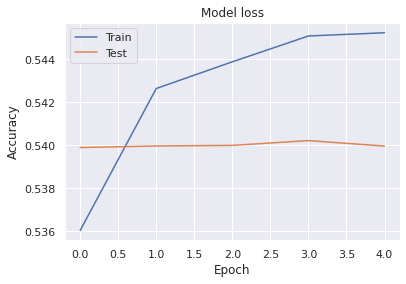

In [14]:
# Plot training & validation accuracy values
plt.plot(mlp_history.history['accuracy'])
plt.plot(mlp_history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

Let's try using the SimpleRNN layers instead of Dense

In [15]:
rnn = Sequential()
rnn.add(Embedding(max_features, 64, input_length=maxlen))
rnn.add(SimpleRNN(100))
rnn.add(Dropout(0.25))
rnn.add(Dense(1, activation='sigmoid'))

rnn.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 64)           1280000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               16500     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,296,601
Trainable params: 1,296,601
Non-trainable params: 0
_________________________________________________________________


In [16]:
rnn_history = mlp.fit(x_train, y_train,
                      batch_size=batch_size, 
                      epochs=5, 
                      validation_data=(x_test,y_test))

Epoch 1/5
782/782 [==============================] - 46s 59ms/step - loss: 0.6798 - accuracy: 0.5453 - val_loss: 0.6850 - val_accuracy: 0.5401
Epoch 2/5
782/782 [==============================] - 52s 67ms/step - loss: 0.6797 - accuracy: 0.5451 - val_loss: 0.6852 - val_accuracy: 0.5401
Epoch 3/5
782/782 [==============================] - 42s 53ms/step - loss: 0.6796 - accuracy: 0.5456 - val_loss: 0.6854 - val_accuracy: 0.5401
Epoch 4/5
782/782 [==============================] - 40s 51ms/step - loss: 0.6795 - accuracy: 0.5453 - val_loss: 0.6852 - val_accuracy: 0.5401
Epoch 5/5
782/782 [==============================] - 43s 56ms/step - loss: 0.6794 - accuracy: 0.5456 - val_loss: 0.6858 - val_accuracy: 0.5402


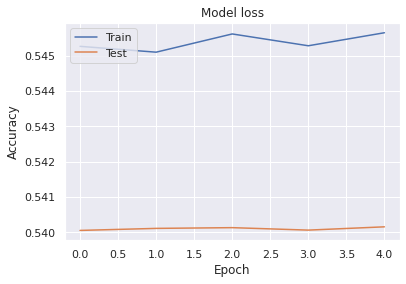

In [17]:
# Plot training & validation accuracy values
plt.plot(rnn_history.history['accuracy'])
plt.plot(rnn_history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

Lastly, let's try replacing the SimpleRNN layer with LSTM.

In [18]:
lstm = Sequential()
lstm.add(Embedding(max_features, 128))

# We are using a fast version of LSTM whih is optimised for GPUs. This layer 
# looks at the sequence of words in the review, along with their word embeddings
# and uses both of these to determine to sentiment of a given review.

# If you wanted to stack multiple LSTM layers:
# model.add(LSTM(256, return_sequences=True))
# model.add(LSTM(128))

# If you wanted to add Bidirectional LSTM:
# lstm.add(Bidirectional(LSTM(128)))

# Note for training on GPU:
# In TensorFlow 2.0, the built-in LSTM and GRU layers have been updated to leverage CuDNN kernels by default when a GPU is available. 
# With this change, the prior keras.layers.CuDNNLSTM/CuDNNGRU layers have been deprecated, and you can build your model without worrying 
# about the hardware it will run on.

# Since the CuDNN kernel is built with certain assumptions, this means the layer will not be able to use the CuDNN kernel if you change the 
# defaults of the built-in LSTM or GRU layers. E.g.:
#   - Changing the activation function from tanh to something else.
#   - Changing the recurrent_activation function from sigmoid to something else.
#   - Using recurrent_dropout > 0.
lstm.add(LSTM(128))
lstm.add(Dropout(0.25))
lstm.add(Dense(1, activation='sigmoid'))

lstm.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [19]:
lstm_history = lstm.fit(x_train, y_train,
                        batch_size=batch_size, 
                        epochs=5, 
                        validation_data=(x_test,y_test))

Epoch 1/5
277/782 [=========>....................] - ETA: 5:04 - loss: 0.4965 - accuracy: 0.7456

KeyboardInterrupt: 

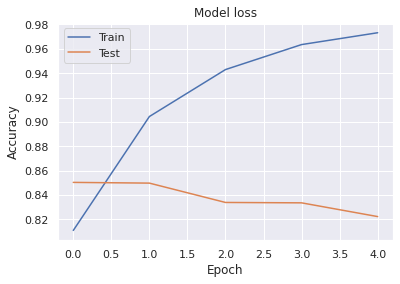

In [ ]:
# Plot training & validation accuracy values
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

## Evaluate model with test data and view results

In [ ]:
# Get Model Predictions for test data
from sklearn.metrics import classification_report

predicted_classes = lstm.predict_classes(x_test)
print(classification_report(y_test, predicted_classes, target_names=class_names))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

    Negative       0.81      0.87      0.83     12500
    Positive       0.85      0.79      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



## View some incorrect predictions

Lets have a look at some of the incorrectly classified reviews. For readability we remove the padding.

In [ ]:
predicted_classes_reshaped = np.reshape(predicted_classes, 25000)

incorrect = np.nonzero(predicted_classes_reshaped != y_test)[0]

# We select the first 10 incorrectly classified reviews
for j, incorrect in enumerate(incorrect[0:3]):
    
    predicted = class_names[predicted_classes_reshaped[incorrect]]
    actual = class_names[y_test[incorrect]]
    human_readable_review = decode_review(x_test[incorrect])
    
    print("Incorrectly classified Test Review ["+ str(j+1) +"]") 
    print("Test Review #" + str(incorrect)  + ": Predicted ["+ predicted + "] Actual ["+ actual + "]")
    print("Test Review Text: " + human_readable_review.replace("<PAD> ", ""))
    print("")

Incorrectly classified Test Review [1]
Test Review #0: Predicted [Positive] Actual [Negative]
Test Review Text: <START> please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss

Incorrectly classified Test Review [2]
Test Review #3: Predicted [Positive] Actual [Negative]
Test Review Text: the mother in this movie is reckless with her children to the point of neglect i wish i wasn't so angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you see her do until the end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audienc

## Run your own text against the trained model

In [ ]:
# Write your own review
review = "this movie was not good"

# Encode review (replace word with integers)
tmp = []
for word in review.split(" "):
    tmp.append(word_index[word])

# Ensure review is 300 words long (by padding or truncating)
tmp_padded = sequence.pad_sequences([tmp], maxlen=maxlen) 

# Run your processed review against the trained model
rawprediction = lstm.predict(np.array([tmp_padded][0]))[0][0]
prediction = int(round(rawprediction))

# Test the model and print the result
print("Review: " + review)
print("Raw Prediction: " + str(rawprediction))
print("Predicted Class: " + class_names[prediction])

Review: this movie was not good
Raw Prediction: 0.09842379
Predicted Class: Negative


## Challenge

You will be expected to use an Keras LSTM for a classicification task on the *Sprint Challenge*. 

Reference for some of the code in the section above can be found: https://github.com/markwest1972/LSTM-Example-Google-Colaboratory/blob/master/LSTM_IMDB_Sentiment_Example.ipynb

# LSTM Text generation with Keras (Learn)

## Overview

What else can we do with LSTMs? Since we're analyzing the *sequence*, we can do more than classify - we can *generate* text. I've pulled some news stories using [newspaper](https://github.com/codelucas/newspaper/).

This example is drawn from the Keras [documentation](https://keras.io/examples/lstm_text_generation/).

In [ ]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import random
import sys
import os

In [ ]:
data_files = os.listdir('./articles')

In [ ]:
# Read in Data

data = []

for file in data_files:
    if file[-3:] == 'txt':
        with open(f'./articles/{file}', 'r', encoding='utf-8') as f:
            data.append(f.read())

In [ ]:
len(data)

136

In [ ]:
data[-2]

"President Trump’s order to withdraw essentially all U.S. forces from northern Syria came after the commander in chief privately agitated for days to bring troops home, according to administration officials — even while the Pentagon was making public assurances that the United States was not abandoning its Kurdish allies in the region.\n\nThe officials, granted anonymity to describe internal deliberations, described Trump as “doubling down” and “undeterred,” despite vociferous pushback from congressional Republicans who have been loath to challenge the president apart from a few issues, such as national security.\n\nBehind the scenes, Trump has tried to convince advisers and lawmakers that the United States is not to blame for Turkey’s military offensive, which has targeted Kurdish fighters who have aided the U.S. fight against the Islamic State.\n\nBut experts — and many Republicans — say otherwise. And even Trump allies say the president needs to do a better job of selling the troop 

In [ ]:
# Encode Data as Chars

# Gather all text 
# Why? 1. See all possible characters 2. For training / splitting later
text = " ".join(data)

# Unique Characters
chars = list(set(text))

# Lookup Tables
char_int = {c:i for i, c in enumerate(chars)} 
int_char = {i:c for i, c in enumerate(chars)} 

In [ ]:
len(chars)

121

In [ ]:
chars

['H',
 '2',
 'è',
 '3',
 'é',
 '⅔',
 '4',
 'ñ',
 ' ',
 'ó',
 "'",
 '/',
 ':',
 'j',
 'd',
 '\n',
 '|',
 'p',
 'o',
 '0',
 'h',
 'Z',
 'W',
 '…',
 '.',
 '⭐',
 '@',
 'e',
 '🤔',
 'J',
 '%',
 '{',
 '‘',
 ')',
 '’',
 'R',
 'F',
 'ã',
 'T',
 '8',
 '½',
 '\u2069',
 '1',
 '?',
 '+',
 'V',
 '👻',
 'r',
 '⅓',
 '[',
 '”',
 '“',
 '6',
 'E',
 'N',
 'k',
 'z',
 'L',
 'ﬂ',
 '_',
 '●',
 's',
 '—',
 '―',
 ';',
 '©',
 '\xad',
 'A',
 'g',
 ',',
 '–',
 '\u2066',
 '7',
 'n',
 'S',
 'M',
 '"',
 'c',
 '🗣',
 'P',
 '#',
 'D',
 '$',
 'x',
 'i',
 '-',
 'm',
 'l',
 'v',
 't',
 'O',
 'f',
 '*',
 '•',
 '5',
 ']',
 'í',
 'Y',
 'u',
 '(',
 '&',
 '9',
 'X',
 'q',
 'G',
 'C',
 '·',
 'b',
 'a',
 'U',
 'K',
 'B',
 'ê',
 'y',
 'á',
 'Q',
 'ö',
 '!',
 'I',
 'w',
 '×']

In [ ]:
# Create the sequence data
maxlen = 40
step = 5

encoded = [char_int[c] for c in text]

sequences = [] # Each element is 40 chars long
next_char = [] # One element for each sequence

for i in range(0, len(encoded) - maxlen, step):
    
    sequences.append(encoded[i : i + maxlen])
    next_char.append(encoded[i + maxlen])
    
print('sequences: ', len(sequences))

sequences:  178374


In [ ]:
chars[18]

'o'

In [ ]:
sequences[0]

[15,
 15,
 75,
 18,
 98,
 47,
 73,
 27,
 47,
 61,
 8,
 108,
 89,
 89,
 27,
 73,
 14,
 8,
 108,
 8,
 91,
 98,
 73,
 27,
 47,
 108,
 87,
 8,
 91,
 18,
 47,
 8,
 110,
 98,
 47,
 14,
 84,
 61,
 20,
 8]

In [ ]:
next_char[0]

17

In [ ]:
[int_char[i] for i in sequences[1]]

['r',
 'n',
 'e',
 'r',
 's',
 ' ',
 'a',
 't',
 't',
 'e',
 'n',
 'd',
 ' ',
 'a',
 ' ',
 'f',
 'u',
 'n',
 'e',
 'r',
 'a',
 'l',
 ' ',
 'f',
 'o',
 'r',
 ' ',
 'K',
 'u',
 'r',
 'd',
 'i',
 's',
 'h',
 ' ',
 'p',
 'o',
 'l',
 'i',
 't']

In [ ]:
int_char[next_char[1]]

'i'

In [ ]:
# Create x & y
x = np.zeros((len(sequences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sequences),len(chars)), dtype=np.bool)

for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        x[i,t,char] = 1
    y[i, next_char[i]] = 1

In [ ]:
x.shape

(178374, 40, 121)

In [ ]:
y.shape

(178374, 121)

In [ ]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [ ]:
# build the model: a single LSTM

model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
def sample(preds):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / 1
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    
    start_index = random.randint(0, len(text) - maxlen - 1) 
    generated = ''
    
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)
    
    for i in range(400):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_int[char]] = 1
            
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds)
        next_char = int_char[next_index]
        
        sentence = sentence[1:] + next_char
        
        sys.stdout.write(next_char)
        sys.stdout.flush()

    print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
# fit the model
model.fit(x, y,
          batch_size=32,
          epochs=10,
          callbacks=[print_callback])

Epoch 1/10
5565/5575 [============================>.] - ETA: 0s - loss: 1.8804
----- Generating text after Epoch: 0
----- Generating with seed: "r-old Robles is back this week, maybe as"
r-old Robles is back this week, maybe ashite” hel may the istaby-croside,” by a home the Aplide woold yeet apsiainsce white laming,” care buich but repressibled frem the crusident of stoped,

“It shet bich wirked, aget or kil are dy sinced thaighome in the 2street that schicution, returt othering hiachmersing to be-mont beed borth-thement that it courtherizur Kursins, shothervisials. (the righter bidew accarging an Ruppec,” Ocriveonchat
5575/5575 [==============================] - 39s 7ms/step - loss: 1.8804
Epoch 2/10
5567/5575 [============================>.] - ETA: 0s - loss: 1.8360
----- Generating text after Epoch: 1
----- Generating with seed: "E COMPANY'S BOARD: "Hunter Biden, facing"
E COMPANY'S BOARD: "Hunter Biden, facing an it the Uariaging Stark twert hincist-uppamed. bring getanizess henee

## Challenge

You will be expected to use a Keras LSTM to generate text on today's assignment. 

# Review

- <a href="#p1">Part 1: </a>Describe Neural Networks used for modeling sequences
    * Sequence Problems:
        - Time Series (like Stock Prices, Weather, etc.)
        - Text Classification
        - Text Generation
        - And many more! :D
    * LSTMs are generally preferred over RNNs for most problems
    * LSTMs are typically a single hidden layer of LSTM type; although, other architectures are possible.
    * Keras has LSTMs/RNN layer types implemented nicely
- <a href="#p2">Part 2: </a>Apply a LSTM to a text generation problem using Keras
    * Shape of input data is very important
    * Can take a while to train
    * You can use it to write movie scripts. :P 